## Building an image classifier in TF2.0 (Practical introduction)

### 1. Downloading and preprocessing data

Installation

In [1]:
!which pip

/home/ubuntu/tf2/bin/pip


In [2]:
!pip install tf-nightly-2.0-preview
!pip install tensorflow-datasets

Importing the required libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
tf.__version__

'2.0.0-dev20190309'

Check out the details (features, statistics, etc.) of the dataset to be downloaded here: https://www.tensorflow.org/datasets/datasets

In [4]:
# List the available datasets
tfds.list_builders()

['bair_robot_pushing_small',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cifar10',
 'cifar100',
 'coco2014',
 'diabetic_retinopathy_detection',
 'dummy_dataset_shared_generator',
 'dummy_mnist',
 'fashion_mnist',
 'image_label_folder',
 'imagenet2012',
 'imdb_reviews',
 'lm1b',
 'lsun',
 'mnist',
 'moving_mnist',
 'nsynth',
 'omniglot',
 'open_images_v4',
 'quickdraw_bitmap',
 'squad',
 'starcraft_video',
 'svhn_cropped',
 'tf_flowers',
 'wmt_translate_ende',
 'wmt_translate_enfr']

Download the dataset using tfds.load()

In [5]:
# Since "tf_flowers" doesn't define standard splits, 
# use the subsplit feature to divide it into (train, validation, test)
# with 80%, 10%, 10% of the data respectively.
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)
(raw_train, raw_validation, raw_test), metadata = tfds.load(name="tf_flowers", 
                                                            with_info=True,
                                                            split=list(splits),
# specifying batch_size=-1 will load full dataset in the memory
#                                                             batch_size=-1,
# as_supervised: `bool`, if `True`, the returned `tf.data.Dataset`
# will have a 2-tuple structure `(input, label)`                                                            
                                                            as_supervised=True)

In [6]:
print(raw_train)
print(raw_validation)
print(raw_test)

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


Set the training image dimensions

In [7]:
IMG_SIZE = 128
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

Create a function which will format the examples in the training dataset as per out needs. The arguments of the `format_example()` depends on the the parameters passed to `tfds.load()`. If `as_supervised=True` then (image, labels) tuple pair will be downloaded else a single dictionary with keys 'image' and 'label' will be passed.

In [9]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    # Resize the image if required
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

Here we'll shuffle the dataset so that we don't have any ordering bias of examples, and create batches of size 32. Setting a shuffle buffer size as large as the dataset ensures that the data is completely shuffled. `.prefetch()` lets the dataset fetch batches, in the background while the model is training.

Without prefetch, the CPU and the GPU/TPU sit idle much of the time

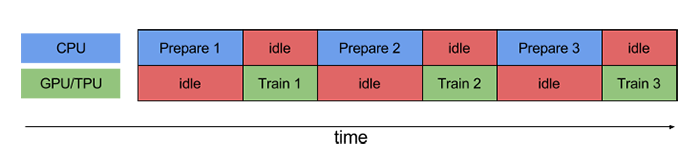

With prefetch, idle time diminishes significantly

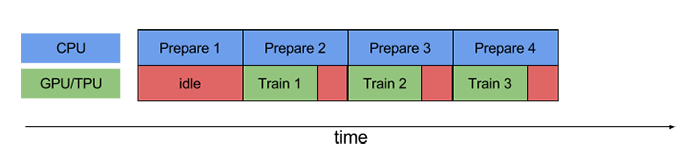

In [10]:
SHUFFLE_BUFFER_SIZE = 1024
BATCH_SIZE = 32

train = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation = validation.batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)
# (Optional) prefetch will enable the input pipeline to asynchronously fetch batches while
# your model is training.
train = train.prefetch(tf.data.experimental.AUTOTUNE)
print(train)
print(validation)
print(test)

<PrefetchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>


There are a few things to note here:

1. The order is important.
    * A `.shuffle()` before a `.repeat()` would shuffle items across epoch boundaries (some items will ve seen twice before others are seen at all).
    * A `.shuffle()` after a `.batch()` would shuffle the order of the batches, but not shuffle the items across batches.
2. We use a `buffer_size` the same size as the dataset for a full shuffle. Up to the dataset size, large values provide better randomization, but use more memory.

3. The shuffle buffer is filled before any elements are pulled from it. So a large `buffer_size` may cause a delay when your `Dataset` is starting.

4. The shuffled dataset doesn't report the end of a dataset until the shuffle-buffer is completely empty. The `Dataset` is restarted by `.repeat()`, causing another wait for the shuffle-buffer to be filled.

This last point can be addressed by using the `tf.data.Dataset.apply` method with the fused `tf.data.experimental.shuffle_and_repeat` function:

```
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds
```

In [11]:
print(metadata)

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=1.0.0,
    description='A large set of images of flowers',
    urls=['http://download.tensorflow.org/example_images/flower_photos.tgz'],
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5)
    },
    total_num_examples=3670,
    splits={
        'train': <tfds.core.SplitInfo num_examples=3670>
    },
    supervised_keys=('image', 'label'),
    citation='"""
        @ONLINE {tfflowers,
        author = "The TensorFlow Team",
        title = "Flowers",
        month = "jan",
        year = "2019",
        url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }
        
    """',
)



<b> 
1. TFDS Reference: https://www.tensorflow.org/datasets/overview
2. For importing data from custom URL or disk location refer, Loading images using tf.data: https://www.tensorflow.org/alpha/tutorials/load_data/images

### Visualizing data

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
# Get the function which converts label indices to string
get_label_name = metadata.features['label'].int2str

Here we fetch the datatset batch by batch and convert it to numpy array just before passing it to plotting function.

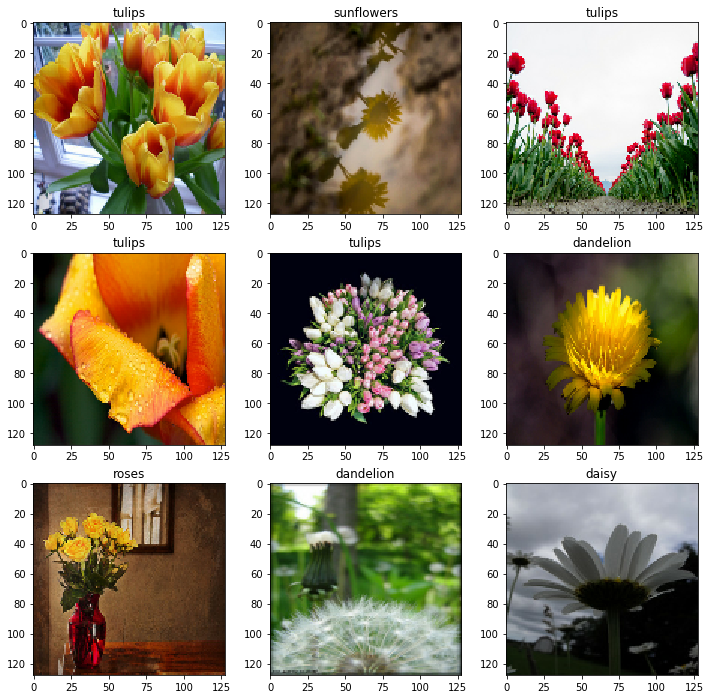

In [14]:
plt.figure(figsize=(12,12)) 
for batch in train.take(1):
    for i in range(9):
        image, label = batch[0][i], batch[1][i]
        plt.subplot(3,3,i+1)
        plt.imshow(image.numpy())
        plt.title(get_label_name(label.numpy()))
        plt.grid(False)

We can also use `tfds.as_numpy(train)` instead of `train.take()` to directly get numpy arrays

In [15]:
plt.figure(figsize=(12,12)) 
count=0
for batch in tfds.as_numpy(train):
    image, label = batch[0], batch[1]
    count+=1
print(count)
print(type(image))
print(image.shape)
print(type(label))
print(label.shape)
#     for i in range(9):
#         image, label = batch[0][i], batch[1][i]
#         plt.subplot(3,3,i+1)
#         plt.imshow(image)
#         plt.title(get_label_name(label))
#         plt.grid(False)

100
<class 'numpy.ndarray'>
(32, 128, 128, 3)
<class 'numpy.ndarray'>
(32,)


<Figure size 864x864 with 0 Axes>

### 2. Building an image classifier model using `tf.keras`

In [16]:
from tensorflow import keras`
keras.__version__

'2.2.4-tf'

`tf.keras` is TensorFlow's implementation of the Keras API specification. This is a high-level API to build and train models that includes first-class support for TensorFlow-specific functionality, such as eager execution, `tf.data` pipelines, and Estimators. `tf.keras` makes TensorFlow easier to use without sacrificing flexibility and performance.

The 6 lines of code below define the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.

As input, a CNN takes tensors of shape `(image_height, image_width, color_channels)`, ignoring the batch size. If you are new to color channels, grayscale images have one, whereas a colored images have three (R,G,B). In this example, we will configure our CNN to process inputs of shape (128, 128, 3). We do this by passing the argument `shape` to our first layer.

To complete our model, we will feed the last output tensor from the convolutional base (of shape (28, 28, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, we will flatten (or unroll) the 3D output to 1D, then add one or more Dense layers on top. Our dataset has 5 classes, we get that value from the metadata of our downloaded dataset. Hence, we use a final Dense layer with 5 outputs and a softmax activation.

In [17]:
# Creating a simple CNN model in keras using functional API
def create_model():
    img_inputs = keras.Input(shape=IMG_SHAPE)
    conv_1 = keras.layers.Conv2D(32, (3, 3), activation='relu')(img_inputs)
    maxpool_1 = keras.layers.MaxPooling2D((2, 2))(conv_1)
    conv_2 = keras.layers.Conv2D(64, (3, 3), activation='relu')(maxpool_1)
    maxpool_2 = keras.layers.MaxPooling2D((2, 2))(conv_2)
    conv_3 = keras.layers.Conv2D(64, (3, 3), activation='relu')(maxpool_2)
    flatten = keras.layers.Flatten()(conv_3)
    dense_1 = keras.layers.Dense(64, activation='relu')(flatten)
    output = keras.layers.Dense(metadata.features['label'].num_classes, activation='softmax')(dense_1)

    model = keras.Model(inputs=img_inputs, outputs=output)
    
    return model

The above model was created using Keras's Functional API. However, another way to create models in Keras is to use Keras's Model Subclassing API. This API follows an object oriented structure to build the build models and define it's forward pass. Check out the twitter micro course by the author of keras himself, Francais Chollet OR have a look at this Pix2Pix GAN example: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/examples/pix2pix/pix2pix_eager.ipynb

`.summary()` gives us the complete model architecture

In [18]:
simple_model = create_model()
simple_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0     

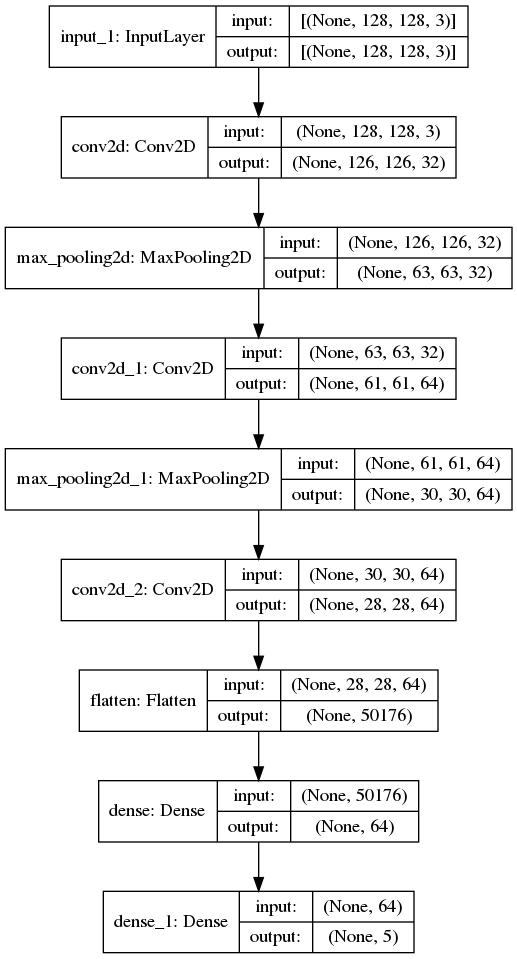

In [19]:
keras.utils.plot_model(simple_model, 'fashion_model_with_shape_info.png', show_shapes=True)

### Setting training parameters

We specifiy the directory where tensorboard can save its logs

In [20]:
import datetime, os

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir)

We also get values of the number of examples in train, val and test sets.
* `steps_per_epoch`: It is the number of batches to train the model in one epoch. Its calculated by dividing the number of training examples by the size of each batch.
* `validation_steps`: It is the same as `steps_per_epoch` but applies to validation dataset

In [21]:
num_train, num_val, num_test = (
  metadata.splits['train'].num_examples * weight/10 for weight in SPLIT_WEIGHTS
)

steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = round(num_val)//BATCH_SIZE

print('Number of examples in the train set:', num_train)
print('Number of examples in the validation set:', num_val)
print('Number of examples in the test set:', num_test)

Number of examples in the train set: 2936.0
Number of examples in the validation set: 367.0
Number of examples in the test set: 367.0


### Compile and train the model

In [22]:
def train_model(model):
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Creating Keras callbacks 
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        'training_checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5', period=5)
    early_stopping_checkpoint = keras.callbacks.EarlyStopping(patience=5)

    history = model.fit(train.repeat(),
              epochs=5, 
              steps_per_epoch=steps_per_epoch,
              validation_data=validation.repeat(),
              validation_steps=validation_steps,
              callbacks=[tensorboard_callback,
                         model_checkpoint_callback,
                         early_stopping_checkpoint])
    
    return history

### Training the model using data augmentation (Optional)

Data augmentation is an important step in training robust deep learning models. While I was exploring TFDS, I couldn't find native functions in tfds library to be applied to perform data augmentation. Hence, I created `manually_train_model()` function which uses `train_on_batch()` and `test_on_batch()` to train the model on data augmented using Keras's `ImageDataGenerator` class. The code is slightly more involved than the standard `model.fit()` call.

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def manually_train_model(model, compile_model=False, epochs=5):
    if compile_model:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

#     tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#     model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
#         'training_checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5', period=5)
#     early_stopping_checkpoint = keras.callbacks.EarlyStopping(patience=5)

# See: https://gist.github.com/joelthchao/ef6caa586b647c3c032a4f84d52e3a11
# For using tensorboard callback with train_on_batch()

    
    datagen = ImageDataGenerator(
    #     featurewise_center=True,
    #     featurewise_std_normalization=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)
    
    # Creating lists to store average of values returned by train_on_batch() and  test_on_batch()
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    # Performing model training for the given number of epochs
    for e in range(epochs):
        print('Epoch', e)
        batches = 0
        loss = 0
        accuracy = 0
        for example in tfds.as_numpy(train):
            x_train, y_train = example[0], example[1]
            for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=BATCH_SIZE):
                curr_loss, curr_accuracy = model.train_on_batch(x_batch, y_batch)
                loss += curr_loss
                accuracy += curr_accuracy
                batches += 1
                if batches >= len(x_train) // 32:
                    # we need to break the loop by hand because
                    # the generator loops indefinitely
                    break
        
        train_losses.append(loss/batches)
        train_accuracies.append(accuracy/batches)
        print('Train Loss:', loss/batches, 'Train Accuracy:', accuracy/batches)
    
        # Calculating validation accuracy and validation loss of the model
        batches = 0
        loss = 0
        accuracy = 0
        # Iterating over validation dataset
        for example in tfds.as_numpy(validation):
            x_train, y_train = example[0], example[1]
            for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=BATCH_SIZE):
                curr_loss, curr_accuracy = model.test_on_batch(x_batch, y_batch)
                loss += curr_loss
                accuracy += curr_accuracy
                batches += 1
                if batches >= len(x_train) // 32:
                    # we need to break the loop by hand because
                    # the generator loops indefinitely
                    break

        valid_losses.append(loss/batches)
        valid_accuracies.append(accuracy/batches)
        print('Val Loss:', loss/batches, 'Val Accuracy:', accuracy/batches)
        batches = 0
    
    return train_losses, train_accuracies, valid_losses, valid_accuracies

Another new feature in TF2.0 is the ability to use full fledged tensorboard inside jupyter notebook itself. We start TensorBoard before starting the model training so that we can view the metrics as and when the model trains.

In [2]:
%load_ext tensorboard.notebook
%tensorboard --logdir logs

In [78]:
# Use the below command to stop tensorboard. You need to pass the process ID
!kill 100276

In [19]:
train_losses, train_accuracies, valid_losses, valid_accuracies = manually_train_model( simple_model, compile_model=True)

# OR

# history = train_model(simple_model)

Epoch 0
Train Loss: 1.333691931962967 Train Accuracy: 0.4303125
Val Loss: 1.208991010983785 Val Accuracy: 0.4335317462682724
Epoch 1
Train Loss: 1.0895640176534653 Train Accuracy: 0.5559375
Val Loss: 1.0914364258448284 Val Accuracy: 0.5476190480921004
Epoch 2
Train Loss: 0.9779948776960373 Train Accuracy: 0.6125
Val Loss: 1.0791311661402385 Val Accuracy: 0.5590277777777778
Epoch 3
Train Loss: 0.9041036051511765 Train Accuracy: 0.6546875
Val Loss: 0.9549024171299405 Val Accuracy: 0.62599206633038
Epoch 4
Train Loss: 0.841822760105133 Train Accuracy: 0.670625
Val Loss: 0.9866574803988138 Val Accuracy: 0.6329365107748244


Plotting the training and validation metrics returned by the `train_model()` routine. We use matplotlib to plot the graph.

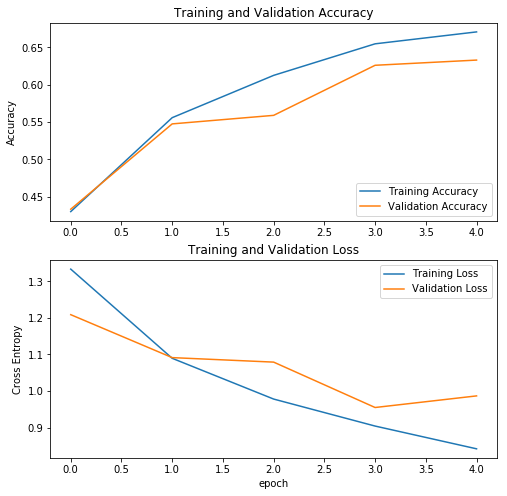

In [21]:
acc = train_accuracies
val_acc = valid_accuracies

loss = train_losses
val_loss = valid_losses

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

These graphs give us insights into how well our model has trained. It is necessary to ensure that both the training and validation accuracies increase and losses decrease.
* If the <b>training accuracy is high but the validation accuracy is low</b>, then it's a typical case of overfitting. You may have to increase your training dataset by performing data augmentation or downloading more images from the internet. You can also try out other model architectures which include regularisation techniques like Dropout and BatchNormalisation.
* If on the other hand your <b>training accuracy and validation accuracy both are higher</b> but, your <b>validation accuracy is slightly higher</b> then maybe your validation dataset comprises of ideal images of the given classes. Sometimes using techniques like dropout and BatchNorm add randomness in training, making training more difficult. To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

### 3. Using pre-trained model

The concept of using pre-trained model is to use models developed by AI giants like Google, Amazon and Micorsoft. These models are pre-trained on the ImageNet dataset which is a large dataset of 1.4M images and 1000 classes of web images. These models have already learned the basic features that are common in 1000 objects that we see daily. Hence, these models have a strong feature extraction capabilty.

In [26]:
from tensorflow import keras

# Create the base model from the pre-trained model MobileNet V2
base_model = keras.applications.InceptionV3(input_shape=IMG_SHAPE,
# We cannot use the top classification layer of the pre-trained model as it contains 1000 classes.
# It also restricts our input dimensions to that which this model is trained on (default: 299x299)
                                               include_top=False, 
                                               weights='imagenet')

87916544/87910968 [==============================] - 710s 8us/step


In [27]:
base_model.trainable = False
# Let's take a look at the base model architecture
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 63, 63, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_94 (Batc (None, 63, 63, 32)   96          conv2d_97[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 63, 63, 32)   0           batch_normalization_v1_94[0][0]  
_______________________________________________________________________________________

In [28]:
keras.utils.plot_model(base_model, 'inception_model_with_shape_info.png', show_shapes=True)

This feature extractor converts each `128x128x3` image to a `2x2x2048` block of features. We will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

NOTE: It's important to freeze the convolutional based before we compile and train the model. By freezing (or setting `layer.trainable = False`), we prevent the weights in these layers from being updated during training.

### Adding classification head

To generate predictions from the block of features, average over the spatial 2x2 spatial locations, using a `tf.keras.layers.GlobalAveragePooling2d` layer to convert the features to a single 2048-element vector per image. On top of apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. 

We stack the feature extractor, and these two layers using a tf.keras.Sequential model. Donot forget to compile the model before training.

In [29]:
def build_model():
    
    model = keras.Sequential([
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(metadata.features['label'].num_classes, 
                           activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

inception_model = build_model()
inception_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


### Train the InceptionV3 model

In [33]:
# Evaluating model before training (Optional)
loss0, accuracy0 = model.evaluate(validation.repeat(), steps = validation_steps)

10/10 [==============================] - 5s 486ms/step - loss: 2.1873 - accuracy: 0.1755


In [ ]:
train_losses, train_accuracies, valid_losses, valid_accuracies = manually_train_model(inception_model)

# OR

# history = model.fit(train.repeat(),
#                     epochs=5,
#                     steps_per_epoch = steps_per_epoch,
#                     validation_data=validation.repeat(), 
#                     validation_steps=validation_steps)

After training the model for 5 epochs we were able to get ~70% accuracy. We plot the learning curves of the training and validation accuracy / loss.

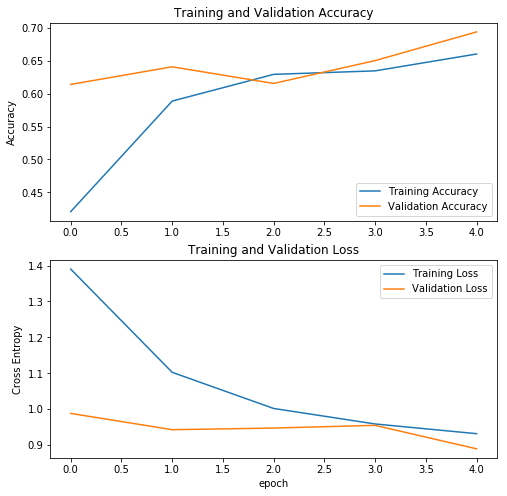

In [28]:
acc = train_accuracies
val_acc = valid_accuracies

loss = train_losses
val_loss = valid_losses

# OR

# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
# Save keras model
inception_model.save('inception_v3_128_tf_flowes.h5')

In [32]:
loaded_model = keras.models.load_model('inception_v3_128_tf_flowes.h5')
loaded_model.evaluate(test)

W0314 18:51:00.480627 140020271679296 hdf5_format.py:261] Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


      7/Unknown - 2s 324ms/step - loss: 0.8607 - accuracy: 0.6900

[0.8606512205941337, 0.69]

### Fine tuning the model

In our feature extraction experiment, we were only training a few layers on top of an Inception V3 base model. The weights of the pre-trained network were <b>not</b> updated during training. One way to increase performance even further is to "fine-tune" the weights of the top layers of the pre-trained model alongside the training of the top-level classifier. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset.

Note: this should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will just forget everything it has learned.

Additionally, the reasoning behind fine-tuning the top layers of the pre-trained model rather than all layers of the pre-trained model is the following: in a convnet, the higher up a layer is, the more specialized it is. The first few layers in a convnet learned very simple and generic features, which generalize to almost all types of images. But as you go higher up, the features are increasingly more specific to the dataset that the model was trained on. The goal of fine-tuning is to adapt these specialized features to work with the new dataset.

In [61]:
# Un-freeze the top layers of the model
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  311


In [34]:
# Fine tune from this layer onwards
fine_tune_at = 249

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
# Compile the model using a much-lower training rate.
inception_model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
inception_model.summary()

Number of layers in the base model:  311
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 11,125,125
Non-trainable params: 10,687,904
_________________________________________________________________


If you trained to convergence earlier, this will get you a few percent more accuracy.

In [35]:
train_losses, train_accuracies, valid_losses, valid_accuracies = manually_train_model(inception_model)

# OR

# history_fine = model.fit(train.repeat(), 
#                          steps_per_epoch = steps_per_epoch,
#                          epochs=10, 
#                          initial_epoch = 5,
#                          validation_data=validation.repeat(), 
#                          validation_steps=validation_steps)

Epoch 0
Train Loss: 0.8866492494940758 Train Accuracy: 0.7090625
Val Loss: 2.5718252460161843 Val Accuracy: 0.7817460298538208
Epoch 1
Train Loss: 0.6015821832418442 Train Accuracy: 0.79625
Val Loss: 0.9219881776306365 Val Accuracy: 0.8278769850730896
Epoch 2
Train Loss: 0.5222328102588654 Train Accuracy: 0.825625
Val Loss: 0.6613628533151414 Val Accuracy: 0.7956349187427096
Epoch 3
Train Loss: 0.44445202603936196 Train Accuracy: 0.8565625
Val Loss: 0.8049592541323768 Val Accuracy: 0.8373015854093764
Epoch 4
Train Loss: 0.40070351541042326 Train Accuracy: 0.8665625
Val Loss: 0.9143406550089518 Val Accuracy: 0.8244047628508674


Note: If the training dataset is fairly small, and is similar to the original datasets that Inception V3 was trained on, so fine-tuning may result in overfitting.

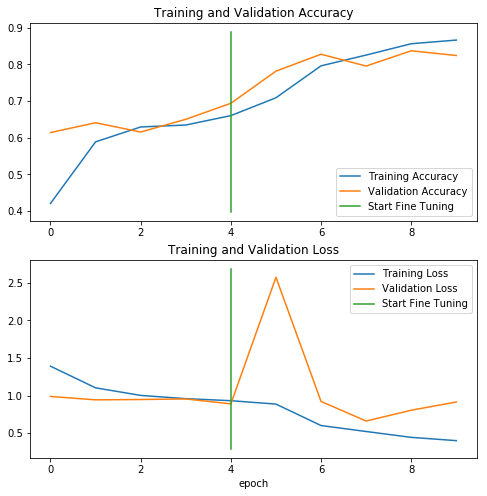

In [36]:
acc += train_accuracies
val_acc += valid_accuracies

loss += train_losses
val_loss += valid_losses

# OR

# acc += history_fine.history['accuracy']
# val_acc += history_fine.history['val_accuracy']

# loss += history_fine.history['loss']
# val_loss += history_fine.history['val_loss']

initial_epochs=5

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1], 
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1], 
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In summary here is what we covered in this tutorial on how to do transfer learning using a pre-trained model to improve accuracy: 
* Using a pre-trained model for <b>feature extraction</b> - when working with a small dataset, it is common to leverage the features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier are updated during training. In this case, the convolutional base extracts all the features associated with each image and we train a classifier that determines, given these set of features to which class it belongs. 
* <b>Fine-tuning</b> a pre-trained model - to further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning. In this case, we tune our weights such that we learn highly specified and high level features specific to our dataset. This only make sense when the training dataset is large and very similar to the orginial dataset that the pre-trained model was trained on.

### 4. Serving model in production

Machine Learning (ML) serving systems need to support model versioning (for model updates with a rollback option) and multiple models (for experimentation via A/B testing), while ensuring that concurrent models achieve high throughput on hardware accelerators (GPUs and TPUs) with low latency. TensorFlow Serving has proven performance handling tens of millions of inferences per second at Google.

### Tensorflow Serving installation
1. Add TensorFlow Serving distribution URI as a package source (one time setup)

    * `~$ echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \`
    * `~$ curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -`

2. Install and update TensorFlow ModelServer

    * `~$ apt-get update && apt-get install tensorflow-model-server`

Once installed, the binary can be invoked using the command `tensorflow_model_server`.

You can upgrade to a newer version of tensorflow-model-server with:

`~$ apt-get upgrade tensorflow-model-server`

Note: In the above commands, replace tensorflow-model-server with tensorflow-model-server-universal if your processor does not support AVX instructions.

In [37]:
from tensorflow import keras

To load our trained model into TensorFlow Serving we first need to save it in SavedModel format. This will create a protobuf file in a well-defined directory hierarchy, and will include a version number. TensorFlow Serving allows us to select which version of a model, or "servable" we want to use when we make inference requests. Each version will be exported to a different sub-directory under the given path.

In [42]:
path_to_saved_model = 'SavedModel/inceptionv3_128_tf_flowes/1'

# Saving the keras model in SavedModel format
keras.experimental.export_saved_model(inception_model, path_to_saved_model)

W0314 19:06:35.579655 140020271679296 deprecation.py:323] From /home/himanshu/tf2/lib/python3.6/site-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:253: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
W0314 19:06:35.581201 140020271679296 tf_logging.py:161] Export includes no default signature!
W0314 19:06:48.823983 140020271679296 tf_logging.py:161] Export includes no default signature!


In [43]:
restored_saved_model = keras.experimental.load_from_saved_model(path_to_saved_model)
# restored_saved_model.predict(test)

### Start running TensorFlow Serving
This is where we start running TensorFlow Serving and load our model. After it loads we can start making inference requests using REST. There are some important parameters:

* `rest_api_port`: The port that you'll use for REST requests.
* `model_name`: You'll use this in the URL of REST requests. It can be anything.
* `model_base_path`: This is the path to the directory where you've saved your model.

In [44]:
!tensorflow_model_server --model_base_path=/home/ubuntu/Desktop/Medium/TF2.0/SavedModel/mobilenetv2_1.00_128_tf_flowes/ --rest_api_port=9000 --model_name=FlowerClassifier

/usr/bin/sh: tensorflow_model_server: command not found


### Make REST requests

In [18]:
import json
import requests
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing import image
import numpy as np

(128, 128, 3)


Text(0.5, 1.0, 'sunflower.jpg')

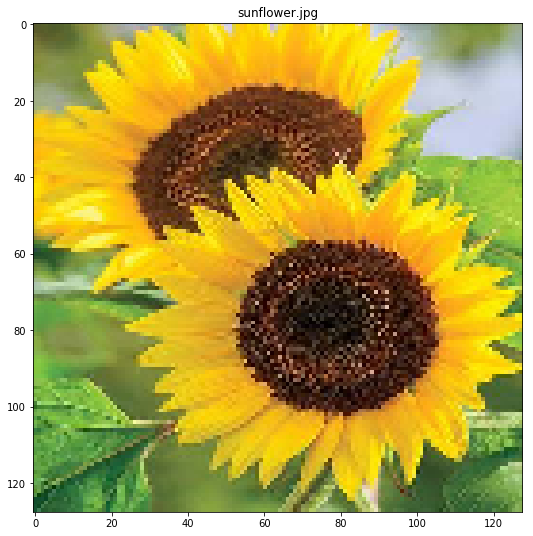

In [7]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

image_path = 'sunflower.jpg'
plt.figure(figsize=(9, 9))
img_array = img_to_array(load_img(image_path, target_size=(128, 128))) / 255.
# img_array = np.expand_dims(img_array, axis=0)
print(img_array.shape)
plt.imshow(img_array)
plt.title(image_path)


In [73]:
def get_top_k_predictions(pred, k=3):
    predictions = np.array(pred['predictions'])[0]
    print('Top {} predictions:'.format(k))
    top_k_indices = np.argpartition(predictions, -k)[-k:]
    top_k_labels = list(map(get_label_name, top_k_indices))
    top_k_scores = predictions[top_k_indices]
    top_k_preds = list(zip(top_k_labels, top_k_scores))
    top_k_preds.sort(key=lambda x: -x[1])
    print(top_k_preds)

We'll send a predict request as a POST to our server's REST endpoint. The URL format follows:
* `POST http://host:port/v1/models/${MODEL_NAME}[/versions/${MODEL_VERSION}]:predict`

`/versions/${MODEL_VERSION}` is optional. If omitted status for all versions is returned in the response.

#### Request format
The request body for predict API must be JSON object formatted as follows:

```
{
  // (Optional) Serving signature to use.
  // If unspecifed default serving signature is used.
  "signature_name": <string>,

  // Input Tensors in row ("instances") or columnar ("inputs") format.
  // A request can have either of them but NOT both.
  "instances": <value>|<(nested)list>|<list-of-objects>
  "inputs": <value>|<(nested)list>|<object>
}
```

Ref: https://www.tensorflow.org/tfx/serving/api_rest#predict_api

In [77]:
# Preprocessing our input image
img = image.img_to_array(image.load_img(image_path, target_size=(128, 128))) / 255.
img = np.expand_dims(img, axis=0)
payload = {"instances": img.tolist()}

# headers = {"content-type": "application/json"}
# sending post request to TensorFlow Serving server
json_response = requests.post('http://localhost:9000/v1/models/FlowerClassifier:predict', json=payload)
pred = json.loads(json_response.content.decode('utf-8'))

# Decoding the response
# decode_predictions(preds, top=5) by default gives top 5 results
# You can pass "k=5" to get top 5 predicitons
get_top_k_predictions(pred, k=3)

Top 3 predictions:
[('sunflowers', 0.978735), ('tulips', 0.0145516), ('roses', 0.00366251)]
